# Exploring the publisher annotations

_All groups: established, non-established, governmental/institutional, other, not\_clear_

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import normaltest, ttest_ind
import seaborn as sns
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from math import sqrt
from util import gather_dataset, z_score_per_worker, z_score_per_task

In [142]:
def load_data(
    publisher_annotations_path: str, claimant_annotations_path: str
) -> pd.DataFrame:
    """Load the annotations annotated publishers, their category, and their average score into a dataframe"""
    publisher_df = pd.read_csv(publisher_annotations_path)
    claimant_df = gather_dataset(claimant_annotations_path)

    # remove zero-scores 
    claimant_df = claimant_df[claimant_df['score'] != 0]

    # perform an inner join on the publisher and claimant dataframes on the publisher name
    joint_df = pd.merge(publisher_df, claimant_df, on='publisher')

    del publisher_df, claimant_df # unload dfs from memory to prevent crashes

    # optionally z-score the scores before performing the statistical tests
    joint_df = z_score_per_task(joint_df)
    joint_df = z_score_per_worker(joint_df)

    # return joint_df

    # group all the claimants by the publisher and calculate the average score for each publisher
    # make sure to keep the mainstream or alternative category
    grouped_df = joint_df.groupby(['publisher', 'category'], as_index=False).agg(
        {'score': 'mean', 'z_score_worker': 'mean', 'z_score_task': 'mean'}
    )

    return grouped_df

stats_df = load_data('./annotations/publisher_annotations.csv', './data/claimant_data_processed/')
stats_df.head()

/home/bbjoverbeek/master_thesis/util.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_scores_df = pd.concat(
/home/bbjoverbeek/master_thesis/util.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_scores_df = pd.concat(


,publisher,category,score,z_score_worker,z_score_task
0,21st Century Wire,not established,2.417384,1.697249e-17,-0.077465
1,@berkeleywellness,other,2.537056,2.214121e-17,-0.071846
2,ABC News,established,4.050718,1.330420e-17,0.009363
3,AGE OF AUTISM,not established,2.016562,2.455074e-17,-0.052952
4,Activist Post,not established,2.441427,1.102471e-17,0.230837


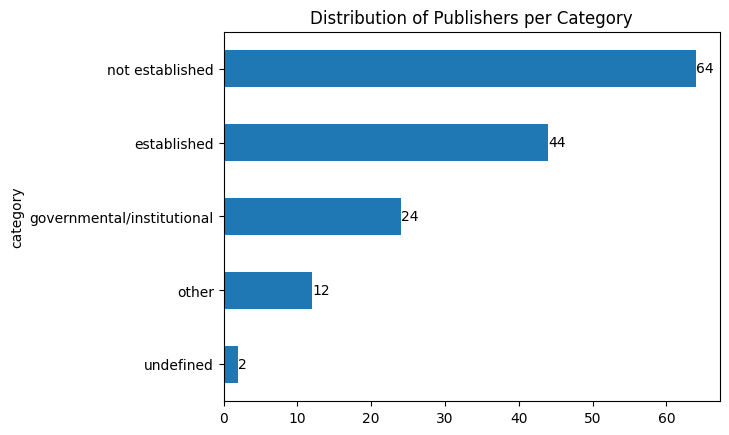

In [171]:
ax = stats_df.value_counts('category', ascending=True).plot(kind='barh', title='Distribution of Publishers per Category', )

for container in ax.containers:
    ax.bar_label(container)

       confidence
count  146.000000
mean     4.424658
std      0.893159
min      2.000000
25%      4.000000
50%      5.000000
75%      5.000000
max      5.000000
                     category  confidence
0                 established    4.681818
1  governmental/institutional    4.875000
2             not established    4.265625
3                       other    3.416667
4                   undefined    4.500000


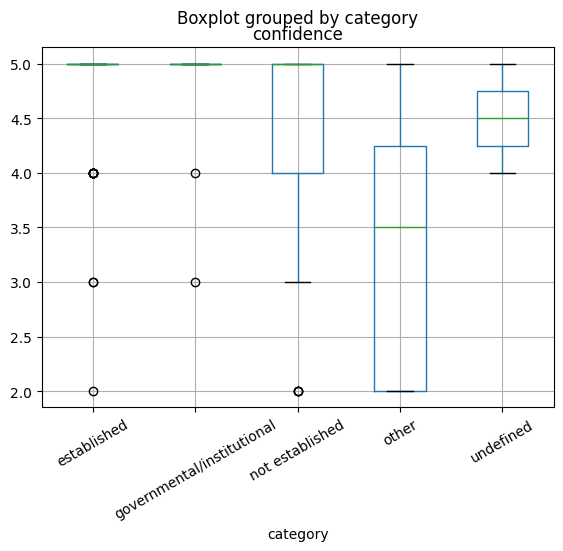

In [179]:
# overall confidence

publisher_df = pd.read_csv('./annotations/publisher_annotations.csv')
publisher_df['confidence'] = publisher_df['confidence'].apply(lambda confidence_stars: confidence_stars.count('★'))

print(publisher_df.describe())

publisher_df.boxplot(column='confidence', by='category', rot=30)

print(publisher_df.groupby(['category'], as_index=False).agg({'confidence': 'mean'}))

del publisher_df

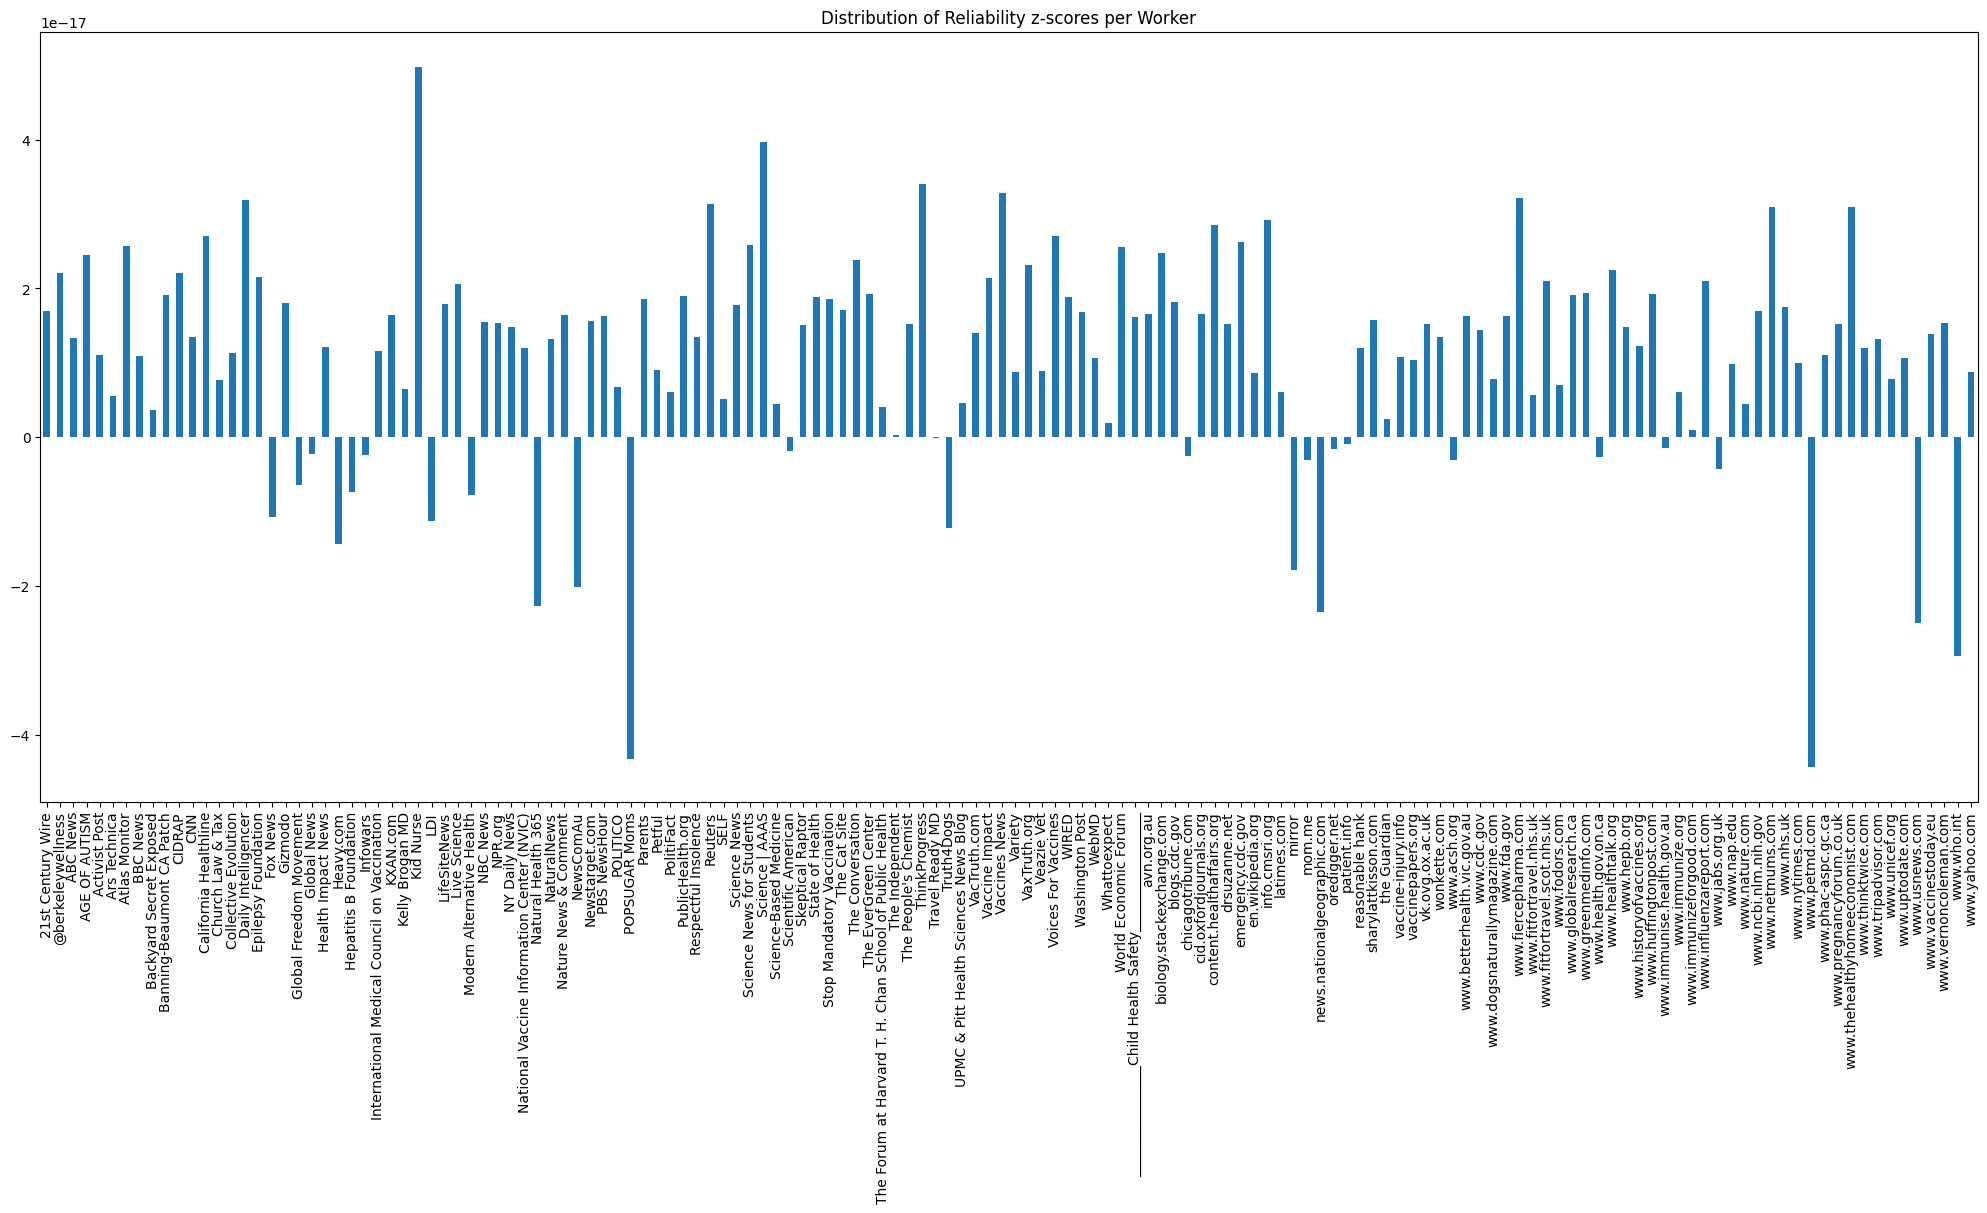

In [144]:
plot = stats_df['z_score_worker'].plot(kind='bar', title='Distribution of Reliability z-scores per Worker', figsize=(25,10))
plot.set_xticklabels(stats_df['publisher'])
plt.show()

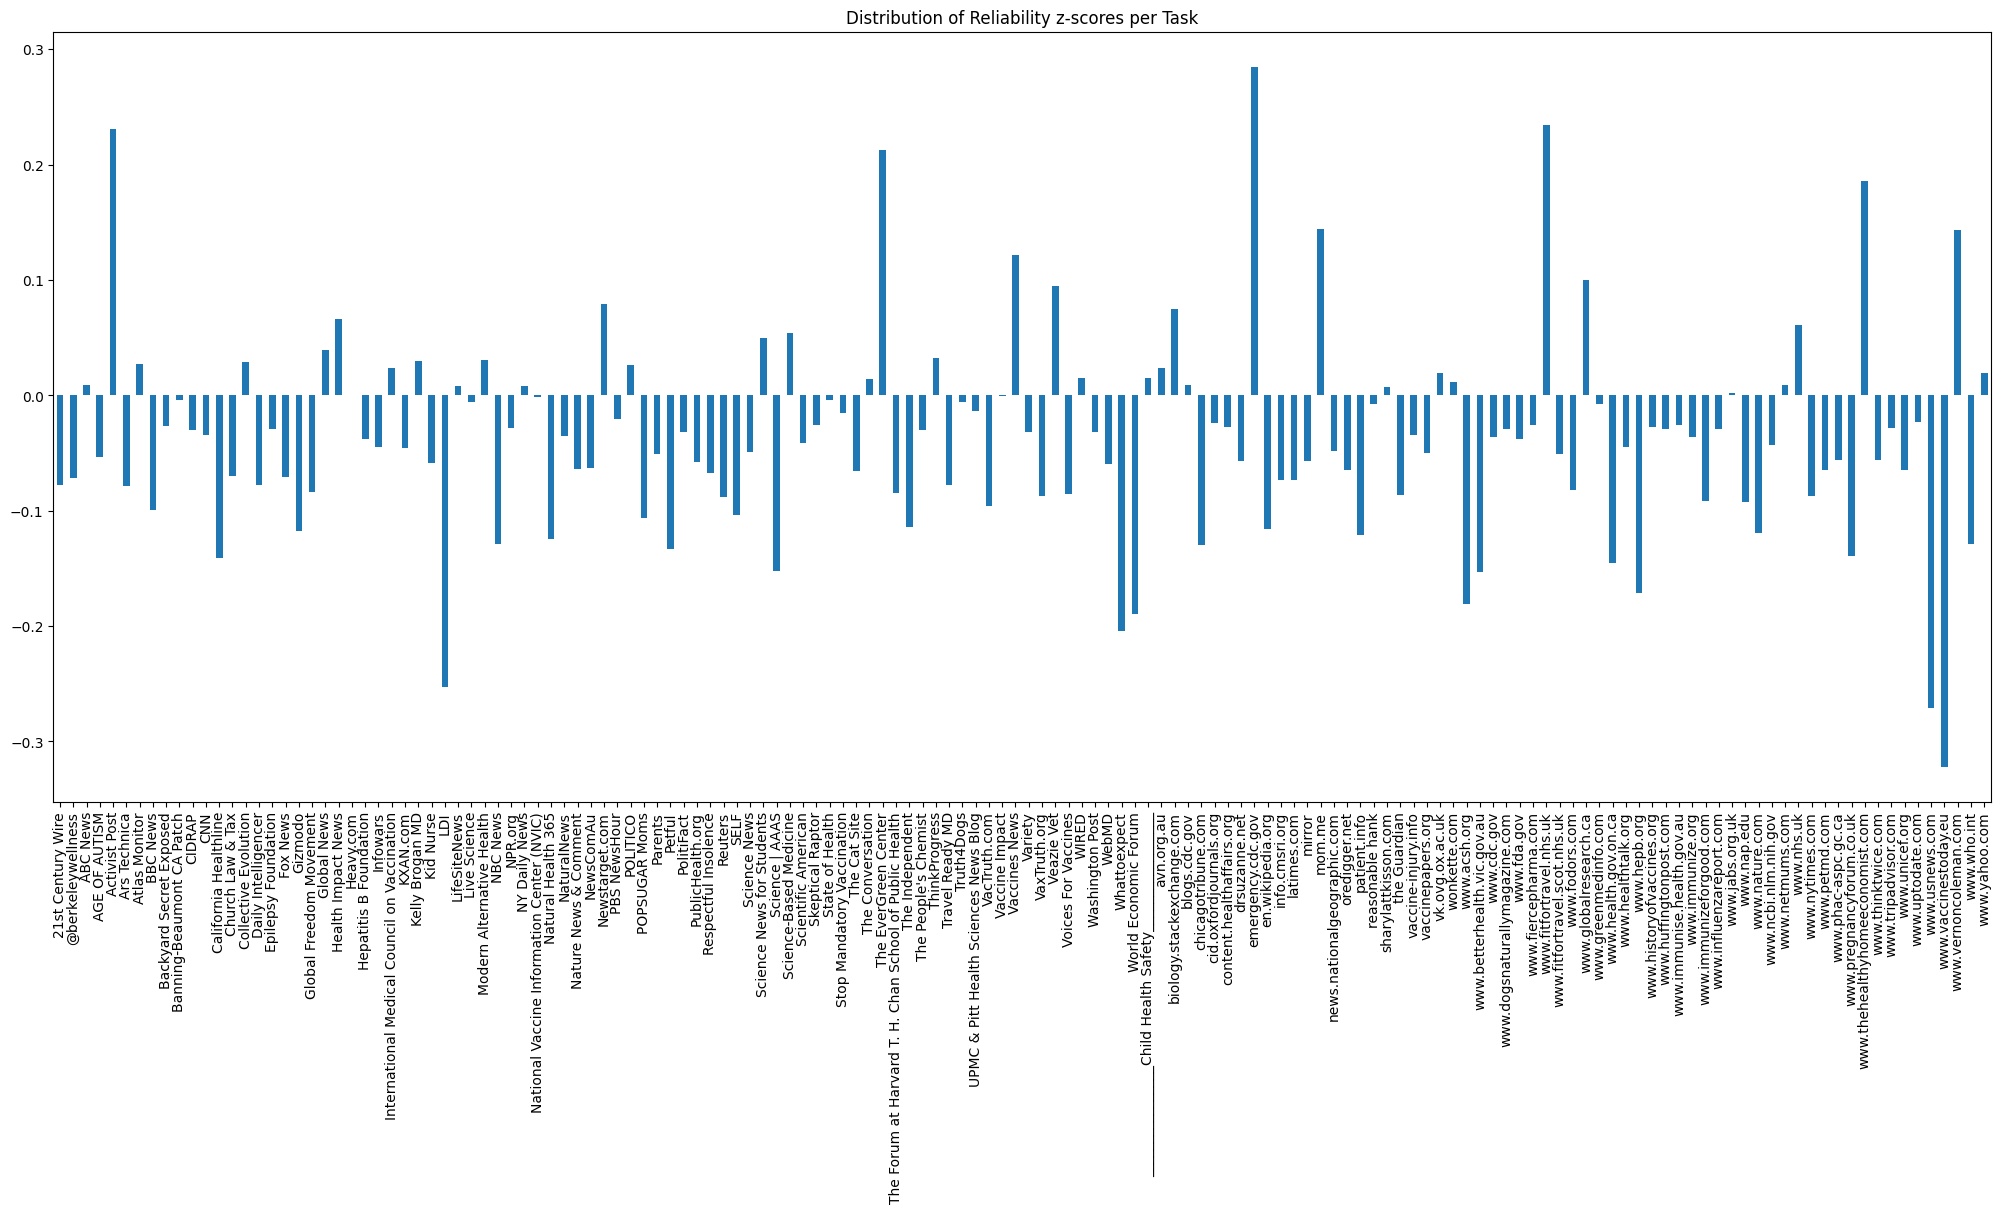

In [145]:
plot = stats_df['z_score_task'].plot(kind='bar', title='Distribution of Reliability z-scores per Task', figsize=(25,10))
plot.set_xticklabels(stats_df['publisher'])
plt.show()

In [146]:
# because the worker z-score average per publisher is much smaller, find a factor to be able to visualize their polarities
# factor = abs(stats_df['z_score_task'].mean()/stats_df['z_score_worker'].mean())
# print(f'multiplying worker z-score with {factor}')
# stats_df['z_score_worker_multiplied'] = stats_df['z_score_worker'].apply(lambda score: score * factor)

# then plot both plots in one graph
# stats_df.plot(x='publisher', y=['z_score_worker_multiplied', 'z_score_task'], kind='bar', figsize=(35, 10), title='Comparison of the Reliability z-scores per Task and per Worker (multiplied)')

### Established vs not-established statistics

In [147]:
from typing import Literal
score_column: Literal['score', 'z_score_worker', 'z_score_task'] = 'score'

In [148]:
# filter df on only established and not established sources
df_filtered2 = stats_df[
    (stats_df['category'] == 'established') | (stats_df['category'] == 'not established')
]

df_filtered2.head()

,publisher,category,score,z_score_worker,z_score_task
0,21st Century Wire,not established,2.417384,1.697249e-17,-0.077465
2,ABC News,established,4.050718,1.330420e-17,0.009363
3,AGE OF AUTISM,not established,2.016562,2.455074e-17,-0.052952
4,Activist Post,not established,2.441427,1.102471e-17,0.230837
5,Ars Technica,established,3.422858,5.493918e-18,-0.078322


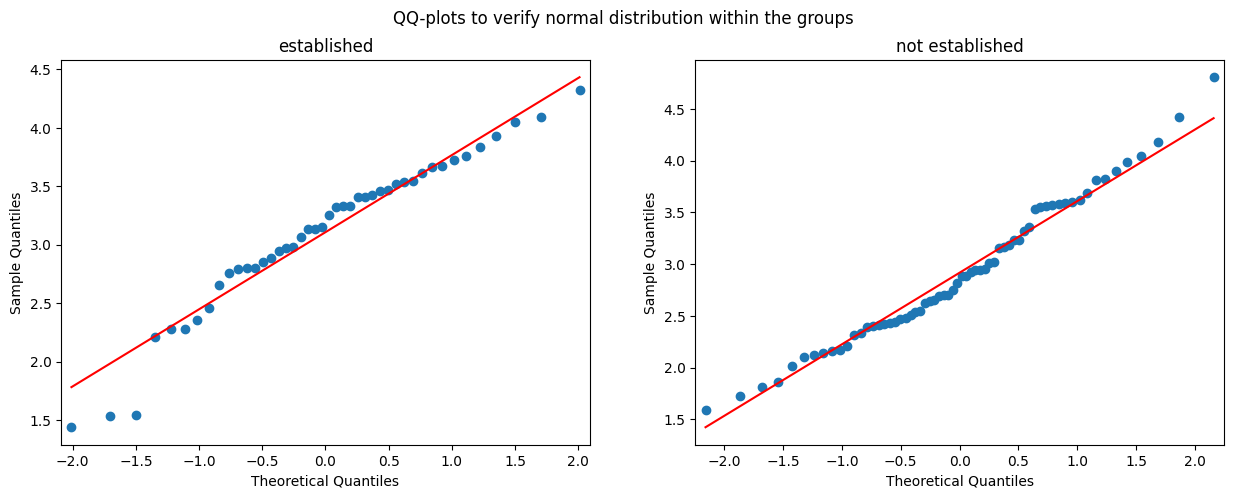

In [149]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('QQ-plots to verify normal distribution within the groups')

linetype: Literal['s','45'] = 's'

sm.qqplot(df_filtered2[df_filtered2['category'] == 'established'][score_column], line=linetype, ax=ax[0]) 
ax[0].set_title('established')

sm.qqplot(df_filtered2[df_filtered2['category'] == 'not established'][score_column], line=linetype, ax=ax[1]) 
ax[1].set_title('not established')

plt.show()

[]

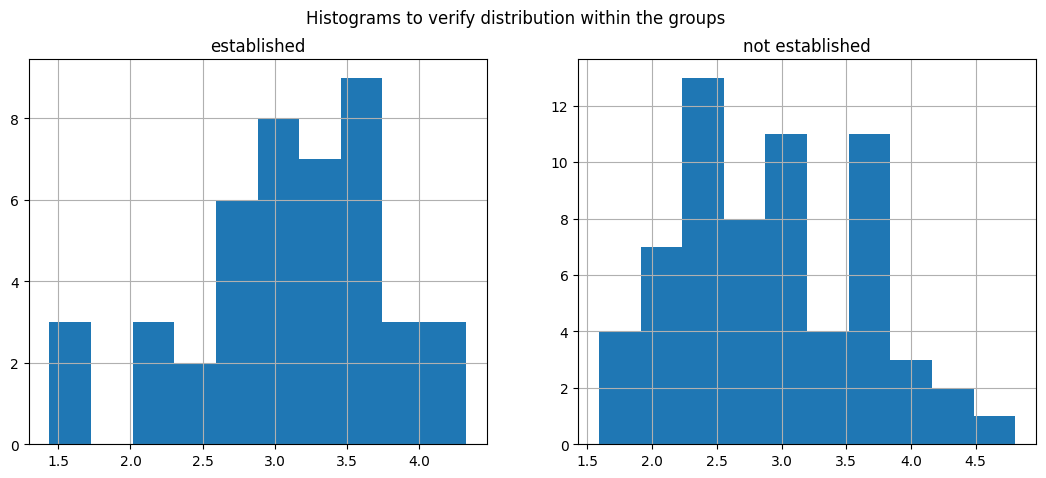

In [150]:
# distribution within each group
fig, ax = plt.subplots(1, 2, figsize=(13,5))
fig.suptitle('Histograms to verify distribution within the groups')

df_filtered2[df_filtered2['category'] == 'established'][score_column].hist(ax=ax[0])
ax[0].set_title('established')

df_filtered2[df_filtered2['category'] == 'not established'][score_column].hist(ax=ax[1])
ax[1].set_title('not established')

plt.plot()

In [151]:
# test for normal distribution
alpha = 0.05
for category in ['established', 'not established']:
    print(f'{category:<50}', end='')
    result = normaltest(df_filtered2[df_filtered2['category'] == category][score_column])
    print(f'statistic: {result.statistic:<6.3f} - p-value: {result.pvalue:.3f}', end=' ')
    print(f'-> {"not normal" if result.pvalue < alpha else "normal"}')

established                                       statistic: 4.990  - p-value: 0.082 -> normal
not established                                   statistic: 2.137  - p-value: 0.344 -> normal


<Axes: title={'center': 'score'}, xlabel='category'>

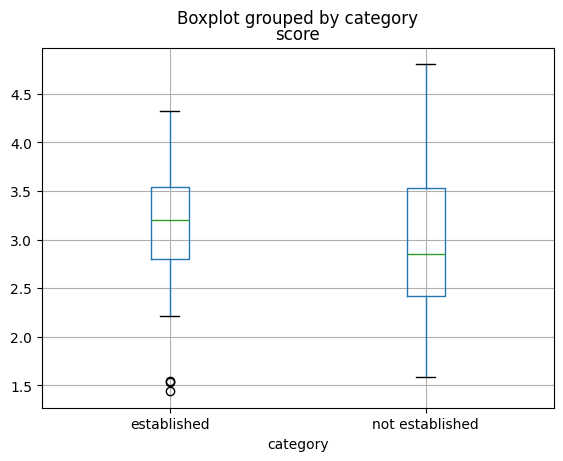

In [152]:
# create boxplot per category
df_filtered2.boxplot(column=score_column, by='category')

In [153]:
# convert the category column to a binary column
df_filtered2.loc[:, 'category'] = df_filtered2['category'].map(
    {'established': 0, 'not established': 1, 0:0, 1:1} # last two are for the case when the column is already binary
)

result = ttest_ind(
    df_filtered2[score_column].to_numpy(), df_filtered2['category'].to_numpy().astype(int), alternative='two-sided'
)

print(
    f't-statistic: {result.statistic}\np-value: {result.pvalue}\ndegrees of freedom: {result.df}'
)

t-statistic: 29.475424462388414
p-value: 2.761402283977638e-77
degrees of freedom: 214.0


In [154]:
# test effect size with cohens d
established_scores = df_filtered2[df_filtered2['category'] == 0][score_column]
not_established_scores = df_filtered2[df_filtered2['category'] == 1][score_column]

cohens_d = (established_scores.mean() - not_established_scores.mean()) / (sqrt((established_scores.std() ** 2 + not_established_scores.std() ** 2) / 2))

print(f'cohens d: {cohens_d}', end=' ')

if cohens_d > 0.8:
    print(' -> large effect size')
elif cohens_d > 0.5:
    print(' -> medium effect size')
elif cohens_d > 0.2:
    print(' -> small effect size')

cohens d: 0.27873676606287145  -> small effect size


### Established / not established / governmental-institutional / other statistics

In [155]:
# filter df to remove `cannot find` items
df_filtered4 = stats_df[
    (stats_df['category'] != 'undefined')
]

# print(f'The resulting categories are: {df_filtered4["category"].unique()}')

df_filtered4.head()

,publisher,category,score,z_score_worker,z_score_task
0,21st Century Wire,not established,2.417384,1.697249e-17,-0.077465
1,@berkeleywellness,other,2.537056,2.214121e-17,-0.071846
2,ABC News,established,4.050718,1.330420e-17,0.009363
3,AGE OF AUTISM,not established,2.016562,2.455074e-17,-0.052952
4,Activist Post,not established,2.441427,1.102471e-17,0.230837


<Axes: title={'center': 'score'}, xlabel='category'>

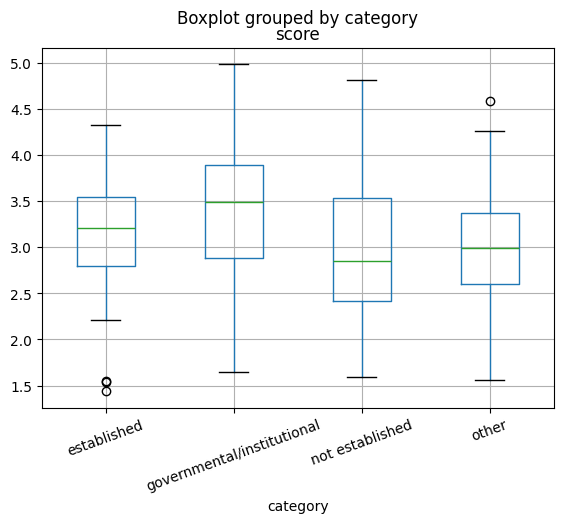

In [156]:
# create boxplot per category
df_filtered4.boxplot(column=score_column, by='category', rot=20)

In [157]:
model = ols(f'{score_column} ~ C(category)', data=df_filtered4).fit()

sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(category),4.655823,3.0,2.960991,0.034433
Residual,73.378047,140.0,NaN,NaN


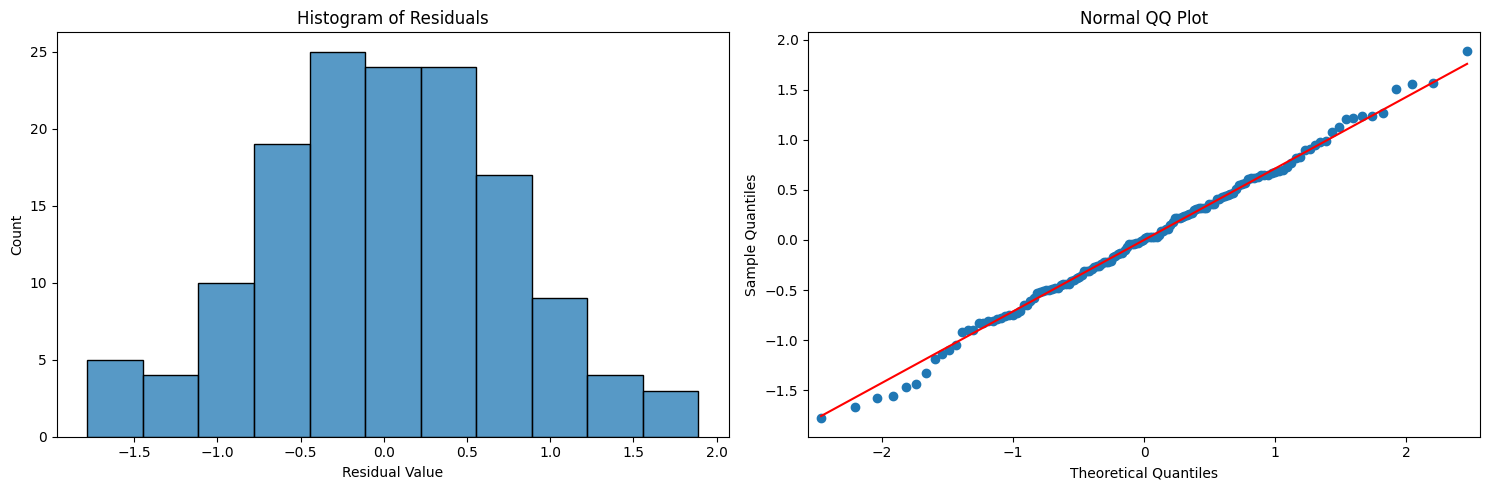

In [158]:
# check for normality assumption

residuals = model.resid

fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.histplot(residuals, ax=ax[0])
ax[0].set_xlabel("Residual Value")
ax[0].set_title("Histogram of Residuals")

sm.qqplot(residuals, line='s',ax = ax[1])
ax[1].set_title("Normal QQ Plot")

plt.tight_layout()
plt.show()

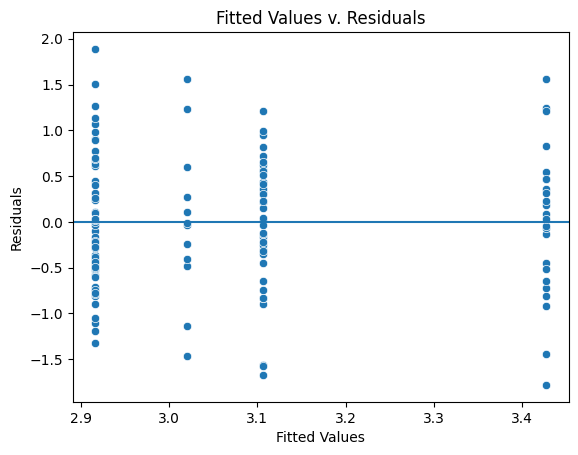

In [159]:
# check for homoscedacity (constant variance) assumption

fig = sns.scatterplot(x = model.fittedvalues, y = model.resid)

fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")

fig.set_title("Fitted Values v. Residuals")
fig.axhline(0)

plt.show()

In [160]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     2.961
Date:                Fri, 28 Jun 2024   Prob (F-statistic):             0.0344
Time:                        16:49:28   Log-Likelihood:                -155.79
No. Observations:                 144   AIC:                             319.6
Df Residuals:                     140   BIC:                             331.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     3.1070      0.109     28.467      0.000       2.891       3.323
C(category)[T.governmental/institutional]     0.3204      0.184      1.744      0.083      -0.043       0.684
C(category)[T.not established]               -0.1901      0.142     -1.341      0.182      -0.470       0.090
C(category)[T.other]                         -0.0869      0.236     -0.369      0.713      -0.553       0.379
==============================================================================
Omnibus:                        0.026   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.987   Jarque-Bera (JB):                0.090
Skew:                          -0.031   Prob(JB):                        0.956
Kurtosis:                       2.895   Cond. No.                         5.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""